In [ ]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import pandas as pd
import pickle
import yaml

import bacco
import baccoemu

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import data_loader
import plotter
import plot_utils
import utils
import generate_params_lh as gplh

%load_ext autoreload
%autoreload 2

2025-05-27 15:42:19.284593: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-27 15:42:19.389348: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-27 15:42:19.389386: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-27 15:42:19.402602: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-27 15:42:19.433316: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
%matplotlib inline
mpl.pyplot.style.use('default')
mpl.pyplot.close('all')

font, rcnew = plot_utils.matplotlib_default_config()
mpl.rc('font', **font)
mpl.pyplot.rcParams.update(rcnew)
mpl.pyplot.style.use('tableau-colorblind10')
%config InlineBackend.figure_format = 'retina'

mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

## Muchisimocks estimate

### Fixed-parameter set to estimate covariance:

In [ ]:
data_mode = 'muchisimocks'
statistics = ['pk']

tag_params = '_quijote_p0_n1000'
tag_biasparams = '_b1000_p0_n1'
tag_datagen = ''
kwargs_data = {
    'tag_datagen': tag_datagen
}

tag_stats = f'_{"_".join(statistics)}'    
tag_data = '_'+data_mode + tag_stats + tag_params + tag_biasparams + tag_datagen

In [ ]:
k_cv, y_cv, y_err_cv, idxs_params, params_df_cv, param_dict_fixed_cv, biasparams_df_cv, biasparams_dict_fixed_cv, random_ints_cosmo_cv, random_ints_bias_cv = \
            data_loader.load_data(data_mode, statistics, 
                                    tag_params, tag_biasparams,
                                    tag_data=tag_data,
                                    kwargs=kwargs_data)
k_cv, y_cv, y_err_cv = k_cv[0], y_cv[0], y_err_cv[0]

Loading muchisimocks data
_b1000_p0_n1
dir statistics /scratch/kstoreyf/muchisimocks/data/pks_mlib/pks_quijote_p0_n1000_b1000_p0_n1
Loaded pk data with shape (1000, 30)
fn_mask: ../data/masks/mask_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1.txt
Loading from ../data/masks/mask_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1.txt (already exists)
Masked 1 out of 30 bins


In [ ]:
params_dict_cv = param_dict_fixed_cv.copy()
params_dict_cv.update(biasparams_dict_fixed_cv)
print(params_dict_cv)

{'omega_cold': 0.3175, 'sigma8_cold': 0.834, 'hubble': 0.6711, 'omega_baryon': 0.049, 'ns': 0.9624, 'neutrino_mass': 0.0, 'w0': -1.0, 'wa': 0.0, 'b1': 1, 'b2': 0, 'bs2': 0, 'bl': 0}


In [ ]:
cov_fid = np.cov(y_cv, rowvar=False)
print(cov_fid.shape)

(29, 29)


In [ ]:
cond_cov = np.linalg.cond(cov_fid)
print("Condition number of cov_fid:", cond_cov)

Condition number of cov_fid: 11603585.349807065


In [ ]:
corr_fid = cov_fid / np.sqrt(np.outer(np.diag(cov_fid), np.diag(cov_fid)))

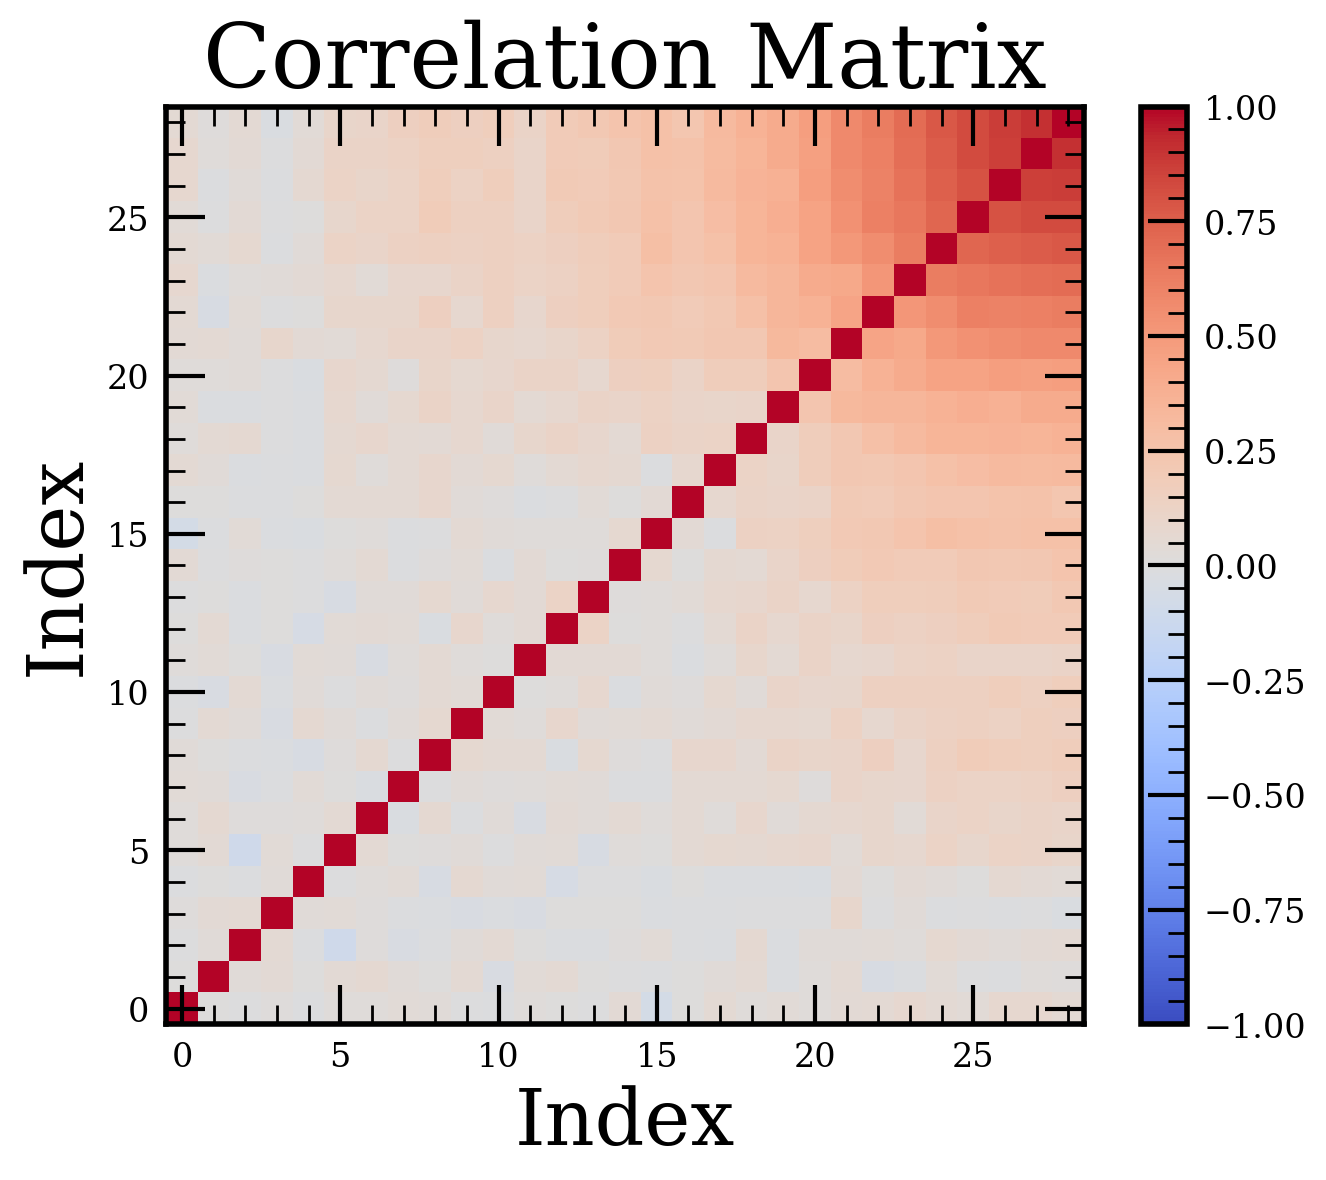

In [ ]:
plt.figure(figsize=(8, 6))
im = plt.imshow(corr_fid, cmap='coolwarm', vmin=-1, vmax=1, aspect='equal', origin='lower')
plt.title('Correlation Matrix')
plt.xlabel('Index')
plt.ylabel('Index')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

### Varying-parameter set to estimate derivatives:

In [ ]:
data_mode = 'muchisimocks'
statistics = ['pk']

tag_params = '_p5_n10000'
tag_biasparams = '_biaszen_p4_n10000'
tag_datagen = ''
kwargs_data = {
    'tag_datagen': tag_datagen
}

tag_stats = f'_{"_".join(statistics)}'    
tag_data = '_'+data_mode + tag_stats + tag_params + tag_biasparams + tag_datagen

In [ ]:
k, y, y_err, idxs_params, params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, random_ints_cosmo, random_ints_bias = \
            data_loader.load_data(data_mode, statistics, 
                                    tag_params, tag_biasparams,
                                    tag_data=tag_data,
                                    kwargs=kwargs_data)
k, y, y_err = k[0], y[0], y_err[0]
print(y.shape)

Loading muchisimocks data
_biaszen_p4_n10000
dir statistics /scratch/kstoreyf/muchisimocks/data/pks_mlib/pks_p5_n10000_biaszen_p4_n10000
Loaded pk data with shape (10000, 30)
fn_mask: ../data/masks/mask_muchisimocks_pk_p5_n10000_biaszen_p4_n10000.txt
Loading from ../data/masks/mask_muchisimocks_pk_p5_n10000_biaszen_p4_n10000.txt (already exists)
Masked 1 out of 30 bins
(10000, 29)


In [ ]:
theta, param_names = data_loader.param_dfs_to_theta(params_df, biasparams_df)
theta_fid = [params_dict_cv[param] for param in param_names]
print(theta.shape, param_names)

(10000, 9) ['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl']


In [ ]:
def fit_derivatives_from_grid(parameters_array, spectra_array, fiducial_params,
                              param_names=None):
    """
    parameters_array: shape (1000, 5) - the cosmological parameters for each spectrum
    spectra_array: shape (1000, n_ell) - the corresponding power spectra
    fiducial_params: shape (5,) - your fiducial parameter values
    """
    derivatives = {}
    n_params = len(fiducial_params)

    if param_names is None:
        param_names = [f'param_{i}' for i in range(n_params)]

    for i in range(n_params):
        # Find spectra close to fiducial in all parameters except i-th
        mask = np.ones(len(parameters_array), dtype=bool)
        for j in range(n_params):
            if j != i:
                # Keep only spectra where other parameters are close to fiducial
                thresh = 0.8 # 10% threshold
                param_range = np.std(parameters_array[:, j]) * thresh  # 10% of std
                mask &= np.abs(parameters_array[:, j] - fiducial_params[j]) < param_range
        
        if np.sum(mask) < 10:  # Need enough points
            raise ValueError(f"Not enough data points for parameter {i}")
        
        # Fit linear relationship between parameter i and spectra
        param_vals = parameters_array[mask, i]
        spectra_subset = spectra_array[mask]
        
        # Fit slope for each multipole
        derivatives[param_names[i]] = np.array([
            np.polyfit(param_vals, spectra_subset[:, ell], 1)[0] 
            for ell in range(spectra_subset.shape[1])
        ])
    
    return derivatives

In [ ]:
derivatives = fit_derivatives_from_grid(
    parameters_array=theta,
    spectra_array=y,
    fiducial_params=theta_fid,
    param_names=param_names
)
print("Derivatives shape:", {k: v.shape for k, v in derivatives.items()})

Derivatives shape: {'omega_cold': (29,), 'sigma8_cold': (29,), 'hubble': (29,), 'omega_baryon': (29,), 'ns': (29,), 'b1': (29,), 'b2': (29,), 'bs2': (29,), 'bl': (29,)}


In [ ]:
def compute_fisher_matrix(derivatives, covariance_matrix):
    param_names = list(derivatives.keys())
    n_params = len(param_names)
    fisher_matrix = np.zeros((n_params, n_params))
    
    # Invert covariance matrix
    cov_inv = np.linalg.inv(covariance_matrix)
    
    for i, param_i in enumerate(param_names):
        for j, param_j in enumerate(param_names):
            fisher_matrix[i, j] = np.dot(derivatives[param_i], 
                                       np.dot(cov_inv, derivatives[param_j]))
    
    return fisher_matrix, param_names

In [ ]:
fisher_matrix, param_names = compute_fisher_matrix(derivatives, cov_fid)
cov_fisher = np.linalg.inv(fisher_matrix)
print("Fisher matrix shape:", fisher_matrix.shape)

Fisher matrix shape: (9, 9)


In [ ]:
n_samples = 10000
samples = np.random.multivariate_normal(theta_fid, cov_fisher, size=n_samples)


In [ ]:
# get bounds
_, dict_bounds_cosmo, _ = gplh.define_LH_cosmo(tag_params)
_, dict_bounds_bias, _ = gplh.define_LH_bias(tag_biasparams)
extents = {**dict_bounds_cosmo, **dict_bounds_bias}

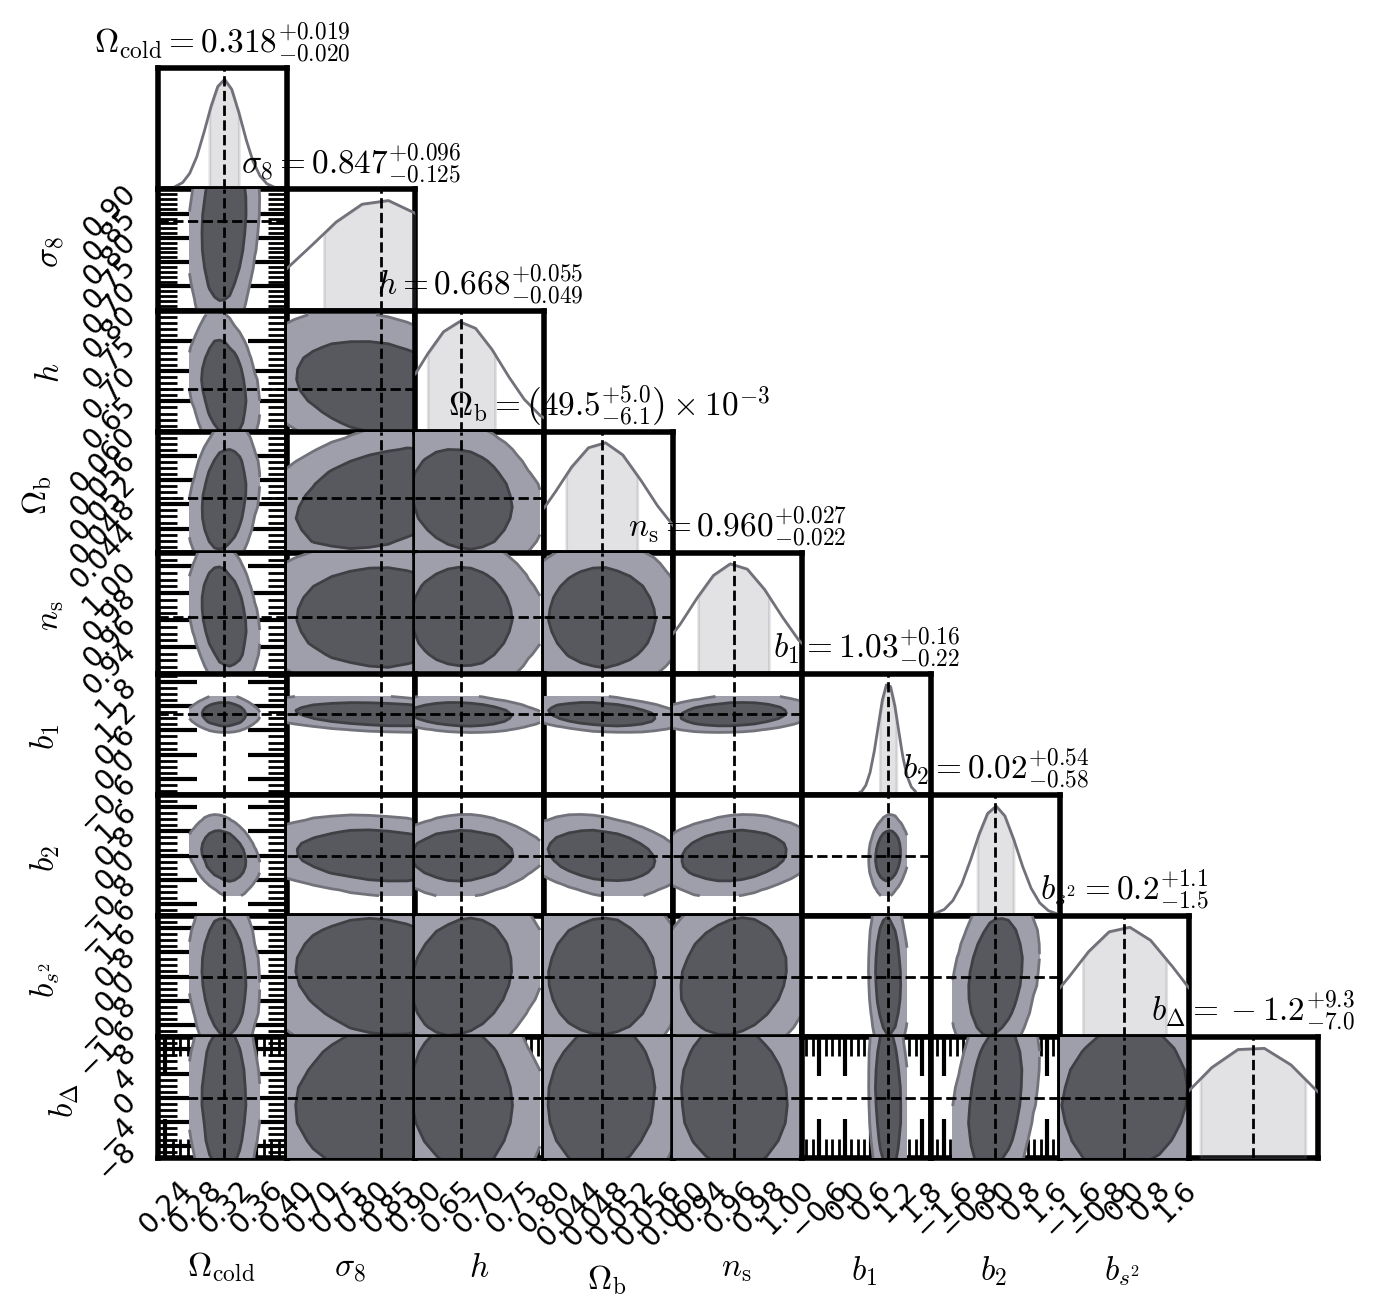

In [ ]:

samples_arr = [samples]
labels = ['Fisher']
colors = ['gray']
plotter.plot_contours(samples_arr, labels, colors, param_names, 
                      utils.param_label_dict, 
                  smooth_arr=[2], bins_arr=[4],
                  truth_loc=params_dict_cv, title=None, extents=extents, 
                  figsize=(7,7), fn_save=None)

## Emulated dataset:

### Fixed param:

In [ ]:
data_mode = 'emuPk'
statistics = ['pk']

tag_params = '_quijote_p0_n1000'
tag_biasparams = '_b1000_p0_n1'
tag_errG = '_boxsize1000'
n_rlzs_per_cosmo = 1
tag_noiseless = ''
#tag_noiseless = '_noiseless' # if use noiseless, set evaluate_mean=False (?)
tag_datagen = f'{tag_errG}_nrlzs{n_rlzs_per_cosmo}'
kwargs_data = {'n_rlzs_per_cosmo': n_rlzs_per_cosmo,
                    'tag_errG': tag_errG,
                    'tag_datagen': tag_datagen,
                    'tag_noiseless': tag_noiseless}
    
tag_stats = f'_{"_".join(statistics)}'    
tag_data = '_'+data_mode + tag_stats + tag_params + tag_biasparams + tag_datagen

In [ ]:
k_cv_emu, y_cv_emu, y_err_cv_emu, idxs_params_emu, params_df_cv_emu, param_dict_fixed_cv_emu, biasparams_df_cv_emu, biasparams_dict_fixed_cv_emu, random_ints_cosmo_cv_emu, random_ints_bias_cv_emu = \
            data_loader.load_data(data_mode, statistics, 
                                    tag_params, tag_biasparams,
                                    tag_data=tag_data,
                                    kwargs=kwargs_data)

../data/emuPks/emuPks_quijote_p0_n1000_b1000_p0_n1/emuPks_noisy_boxsize1000_nrlzs1.npy
(1000, 30)


Text(0, 0.5, '$P(k)\\ [\\mathrm{Mpc}^3/h^3]$')

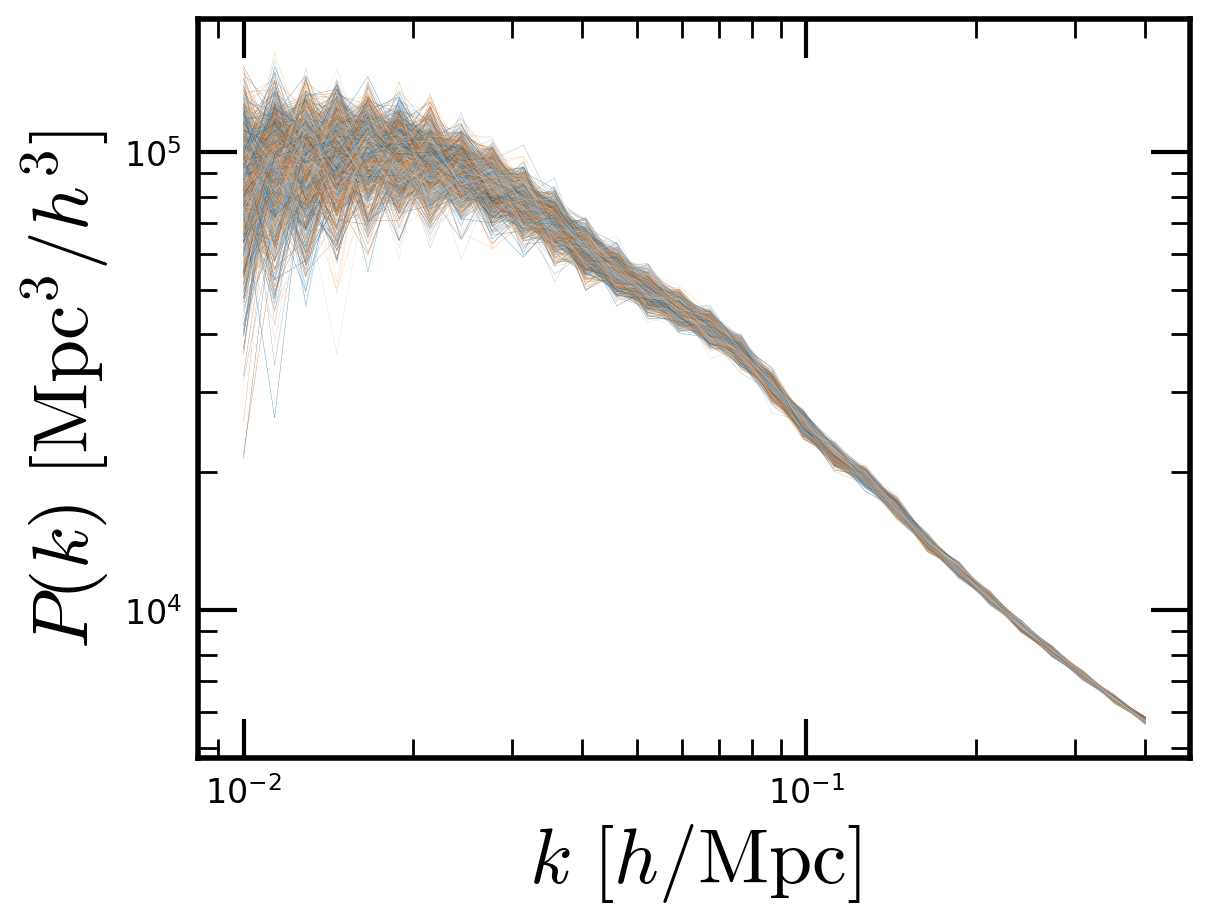

In [ ]:
plt.loglog(k_cv_emu, y_cv_emu.T, lw=0.1)
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P(k)\ [\mathrm{Mpc}^3/h^3]$')

In [ ]:
params_dict_cv_emu = param_dict_fixed_cv_emu.copy()
params_dict_cv_emu.update(biasparams_dict_fixed_cv_emu)
print(params_dict_cv_emu)

{'omega_cold': 0.3175, 'sigma8_cold': 0.834, 'hubble': 0.6711, 'omega_baryon': 0.049, 'ns': 0.9624, 'neutrino_mass': 0.0, 'w0': -1.0, 'wa': 0.0, 'b1': 1, 'b2': 0, 'bs2': 0, 'bl': 0}


In [ ]:
cov_fid_emu = np.cov(y_cv_emu, rowvar=False)
print(cov_fid_emu.shape)

(30, 30)


In [ ]:
cond_cov_emu = np.linalg.cond(cov_fid_emu)
print("Condition number of cov_fid_emu:", cond_cov_emu)

Condition number of cov_fid_emu: 388359.51181085256


In [ ]:
corr_fid_emu = cov_fid_emu / np.sqrt(np.outer(np.diag(cov_fid_emu), np.diag(cov_fid_emu)))

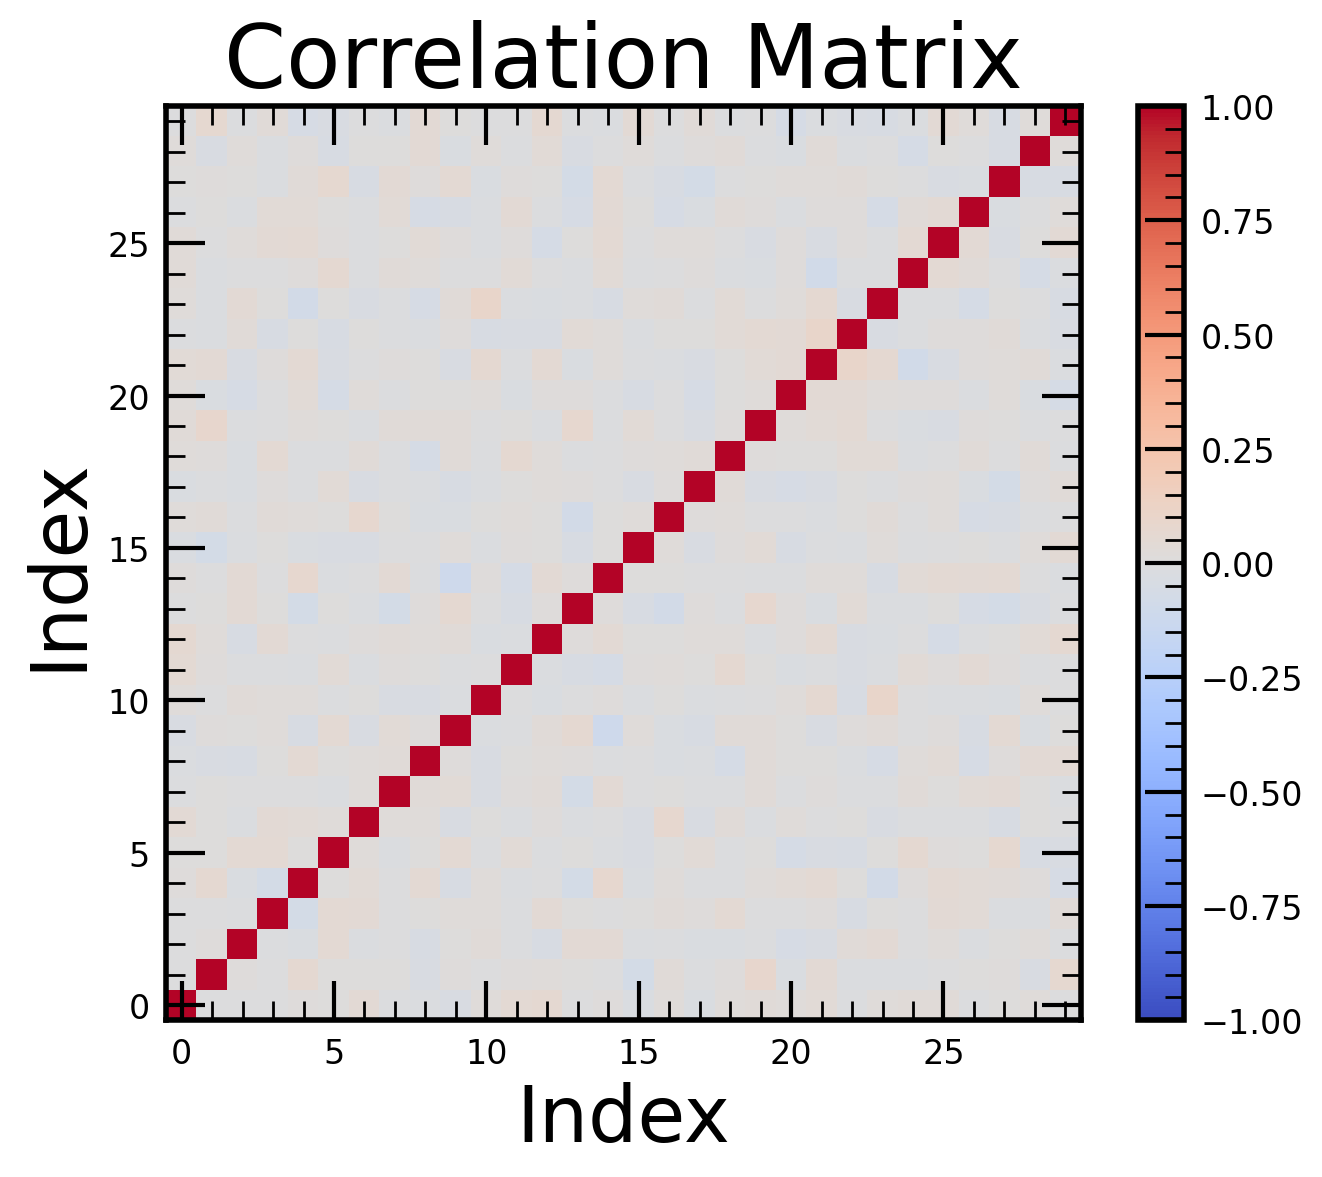

In [ ]:
plt.figure(figsize=(8, 6))
im = plt.imshow(corr_fid_emu, cmap='coolwarm', vmin=-1, vmax=1, aspect='equal', origin='lower')
plt.title('Correlation Matrix')
plt.xlabel('Index')
plt.ylabel('Index')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

### Emu, varying-parameter set:

In [ ]:
data_mode = 'emuPk'
statistics = ['pk']

tag_params = '_p5_n10000'
tag_biasparams = '_biaszen_p4_n10000'
tag_errG = '_boxsize1000'
n_rlzs_per_cosmo = 1
tag_noiseless = ''
#tag_noiseless = '_noiseless' # if use noiseless, set evaluate_mean=False (?)
tag_datagen = f'{tag_errG}_nrlzs{n_rlzs_per_cosmo}'
kwargs_data = {'n_rlzs_per_cosmo': n_rlzs_per_cosmo,
                    'tag_errG': tag_errG,
                    'tag_datagen': tag_datagen,
                    'tag_noiseless': tag_noiseless}
    
tag_stats = f'_{"_".join(statistics)}'    
tag_data = '_'+data_mode + tag_stats + tag_params + tag_biasparams + tag_datagen

In [ ]:
k_emu, y_emu, y_err_emu, idxs_params_emu, params_df_emu, param_dict_fixed_emu, biasparams_df_emu, biasparams_dict_fixed_emu, random_ints_cosmo_emu, random_ints_bias_emu = \
            data_loader.load_data(data_mode, statistics, 
                                    tag_params, tag_biasparams,
                                    tag_data=tag_data,
                                    kwargs=kwargs_data)
#k, y, y_err = k[0], y[0], y_err[0]

../data/emuPks/emuPks_p5_n10000_biaszen_p4_n10000/emuPks_noisy_boxsize1000_nrlzs1.npy
(10000, 30)


Text(0, 0.5, '$P(k)\\ [\\mathrm{Mpc}^3/h^3]$')

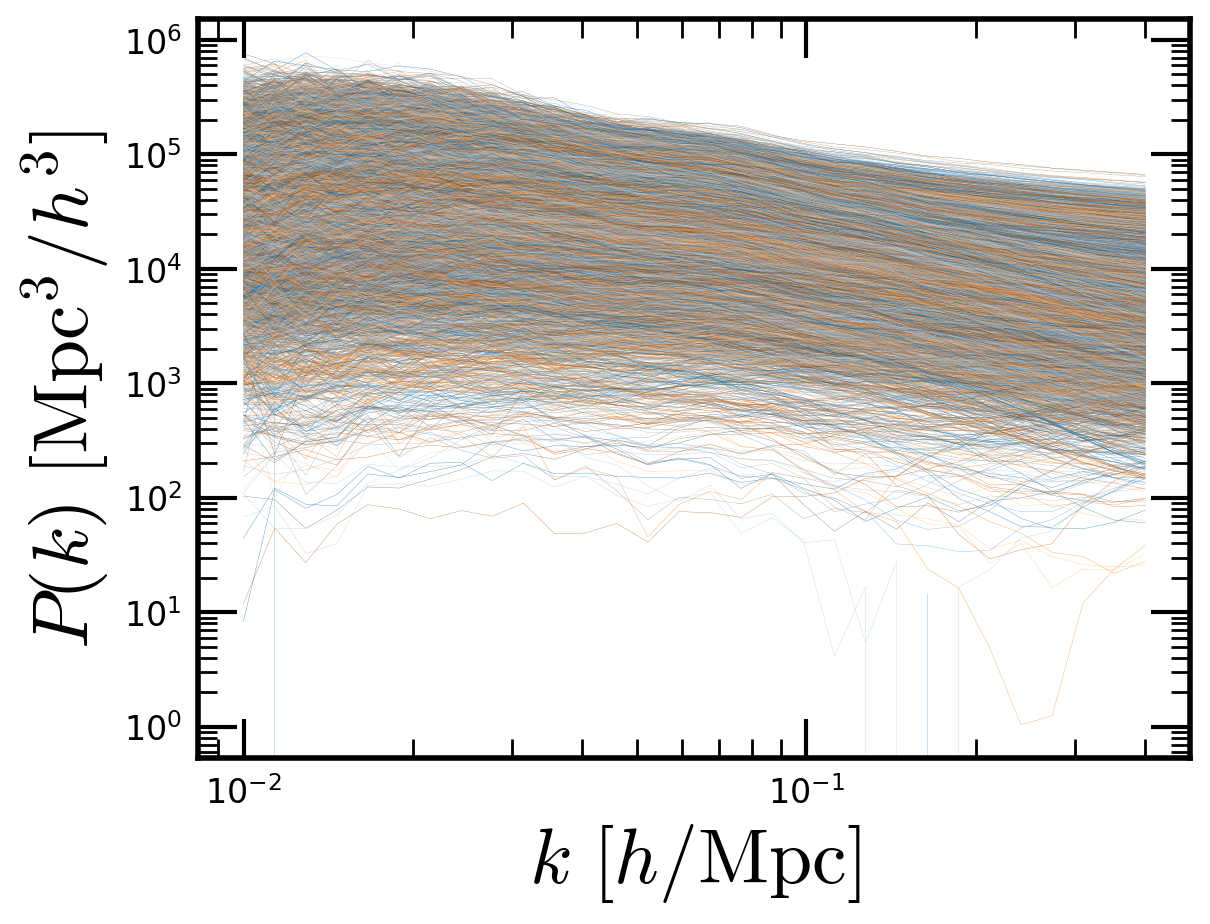

In [ ]:
plt.loglog(k_emu, y_emu.T, lw=0.1)
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P(k)\ [\mathrm{Mpc}^3/h^3]$')

In [ ]:
theta_emu, param_names_emu = data_loader.param_dfs_to_theta(params_df_emu, biasparams_df_emu)
theta_fid_emu = [params_dict_cv_emu[param] for param in param_names_emu]
print(theta_emu.shape, param_names_emu)

(10000, 9) ['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl']


In [ ]:
derivatives_emu = fit_derivatives_from_grid(
    parameters_array=theta_emu,
    spectra_array=y_emu,
    fiducial_params=theta_fid_emu,
    param_names=param_names_emu
)
print("Derivatives shape:", {k: v.shape for k, v in derivatives_emu.items()})

Derivatives shape: {'omega_cold': (30,), 'sigma8_cold': (30,), 'hubble': (30,), 'omega_baryon': (30,), 'ns': (30,), 'b1': (30,), 'b2': (30,), 'bs2': (30,), 'bl': (30,)}


try also computing derivatives more directly bc we have emu 

In [ ]:
dir_emus_lbias = '/home/kstoreyf/external' #hyperion path
emu, emu_bounds, emu_param_names_all = utils.load_emu(dir_emus_lbias=dir_emus_lbias)  

In [ ]:
def estimate_derivatives_emu_shift(emu, k, fiducial_param_dict, delta_frac=0.01):
    derivatives = {}
    bias_params = [fiducial_param_dict[bn] for bn in utils.biasparam_names_ordered]
    cosmo_params = [fiducial_param_dict[pn] for pn in utils.cosmo_param_names_ordered]
    fiducial_params = bias_params.extend(cosmo_params)
    _, pk_fid, _ = emu.get_galaxy_real_pk(bias=bias_params, k=k, 
                                                **cosmo_params)    
    for i, param in enumerate(param_names):
        # Forward difference
        params_plus = fiducial_params.copy()
        params_plus[i] *= (1 + delta_frac)
        _, pk_plus, _ = emu.get_galaxy_real_pk(bias=params_plus[5:], k=k, 
                                                **params_minus[:5])    
        
        # Backward difference 
        params_minus = fiducial_params.copy()
        params_minus[i] *= (1 - delta_frac)
        _, pk_minus, _ = emu.get_galaxy_real_pk(bias=params_minus[5:], k=k, 
                                                **params_minus[:5])    
        
        # Central difference
        derivatives[param] = (pk_plus - pk_minus) / (2 * delta_frac * fiducial_params[i])
    
    return derivatives

In [ ]:
derivatives_emu_shift = estimate_derivatives_emu_shift(emu, k_cv_emu, params_dict_cv_emu)
print("Derivatives shift shape:", {k: v.shape for k, v in derivatives_emu_shift.items()})

In [ ]:
fisher_matrix_emu, param_names = compute_fisher_matrix(derivatives_emu, cov_fid_emu)
cov_fisher_emu = np.linalg.inv(fisher_matrix_emu)
print("Fisher matrix shape:", fisher_matrix_emu.shape)

Fisher matrix shape: (9, 9)


In [ ]:
n_samples = 10000
samples_emu = np.random.multivariate_normal(theta_fid, cov_fisher_emu, size=n_samples)


In [ ]:
# get bounds
_, dict_bounds_cosmo, _ = gplh.define_LH_cosmo(tag_params)
_, dict_bounds_bias, _ = gplh.define_LH_bias(tag_biasparams)
extents = {**dict_bounds_cosmo, **dict_bounds_bias}

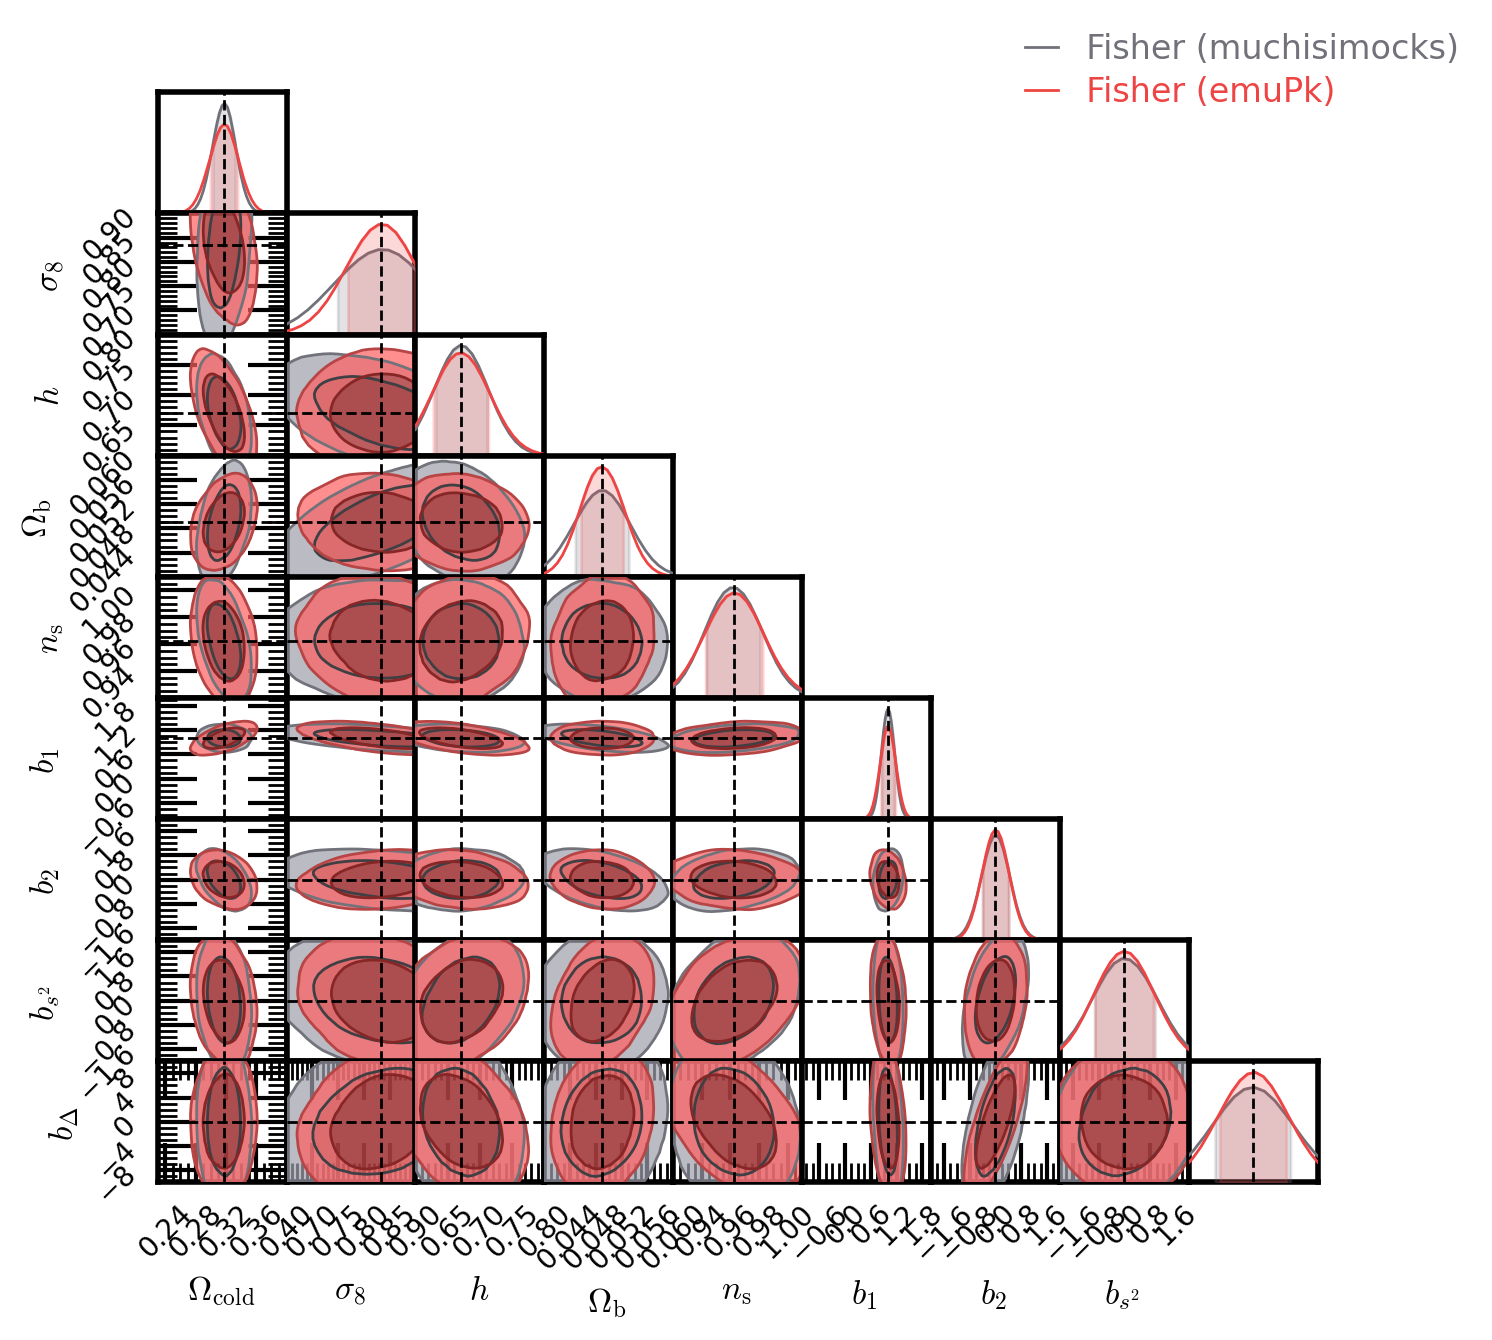

In [ ]:

samples_arr = [samples, samples_emu]
labels = ['Fisher (muchisimocks)', 'Fisher (emuPk)']
colors = ['gray', 'red']
plotter.plot_contours(samples_arr, labels, colors, param_names, 
                      utils.param_label_dict, 
                  smooth_arr=[2,2], bins_arr=[10,10],
                  truth_loc=params_dict_cv, title=None, extents=extents, 
                  figsize=(7,7), fn_save=None)

## Compare covariances

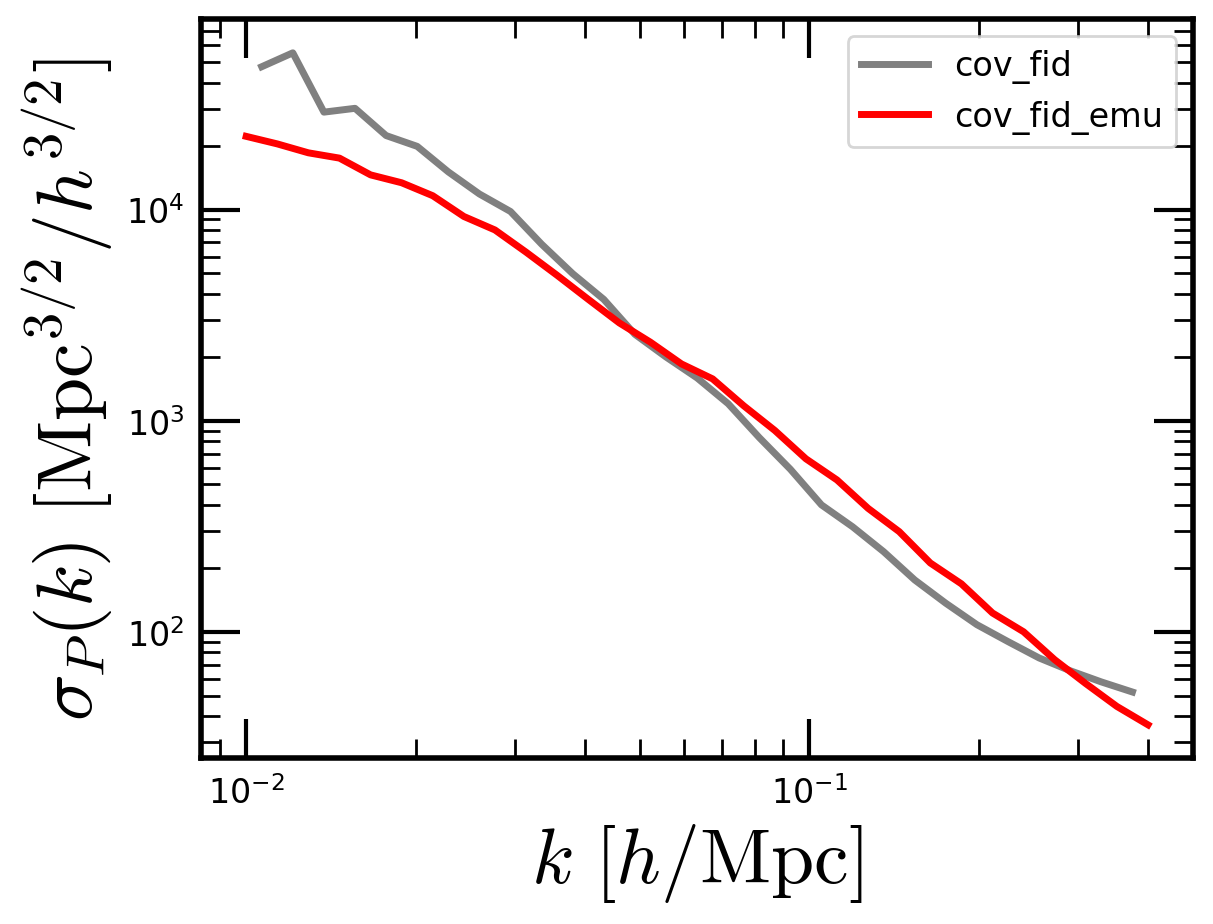

In [ ]:
plt.plot(k_cv, np.sqrt(np.diag(cov_fid)), label='cov_fid', color='gray')
plt.plot(k_emu, np.sqrt(np.diag(cov_fid_emu)), label='cov_fid_emu', color='red')
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$\sigma_P(k)\ [\mathrm{Mpc}^{3/2}/h^{3/2}]$')
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=12)


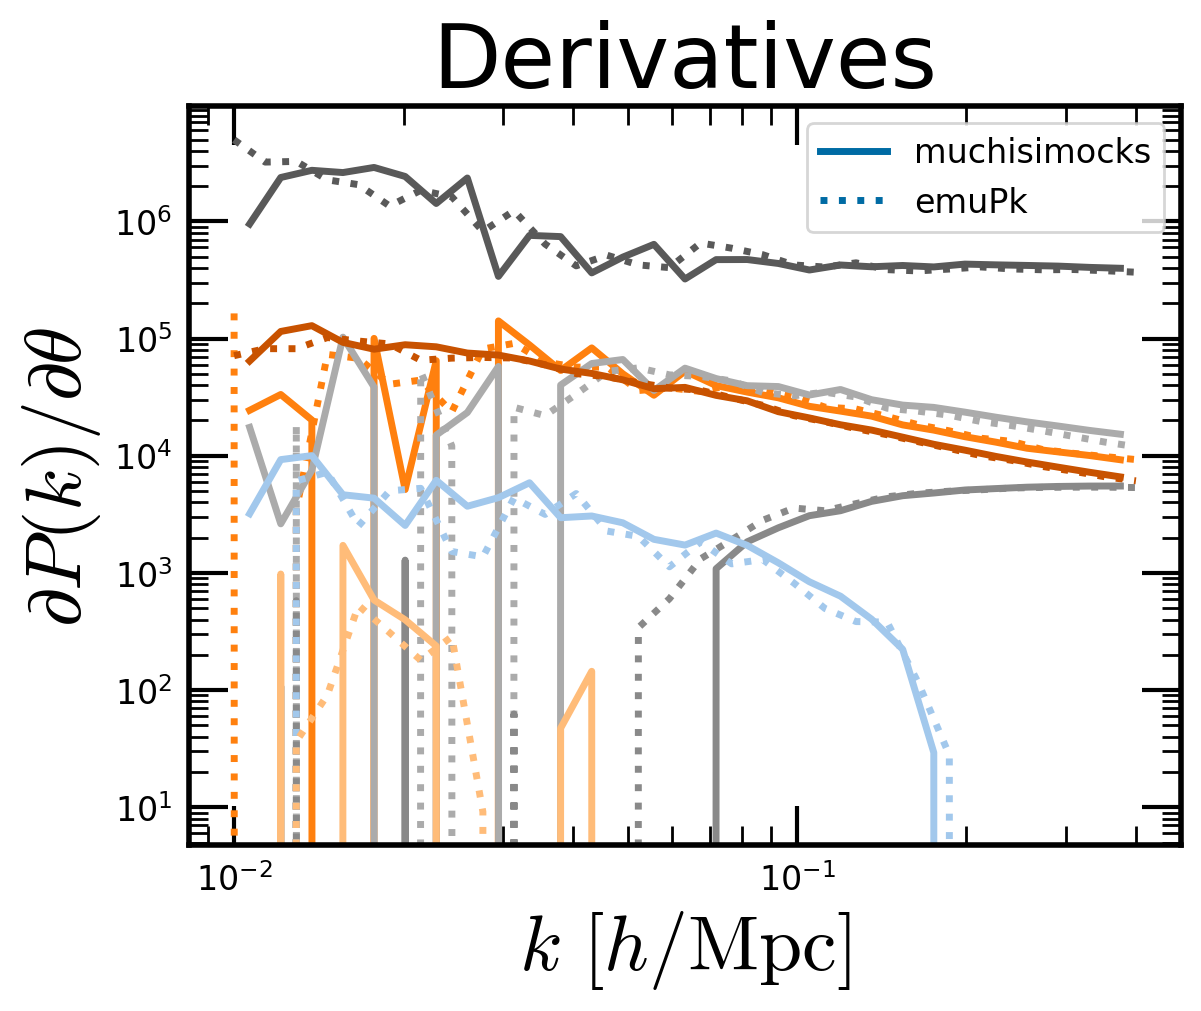

In [ ]:
for i, param_name in enumerate(derivatives.keys()):
    if i==0:
        label_muchisimocks = 'muchisimocks'
        label_emuPk = 'emuPk'
    else:
        label_muchisimocks = None
        label_emuPk = None
    plt.plot(k, derivatives[param_name], label=label_muchisimocks, color=f'C{i}')
    plt.plot(k_emu, derivatives_emu[param_name], label=label_emuPk, ls=':', color=f'C{i}')
#plt.plot(k_emu, np.sqrt(np.diag(cov_fid_emu)), label='cov_fid_emu', color='red')

plt.title(f'Derivatives')
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$\partial P(k) / \partial \theta$')
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=12)
